# Common UK birds multiclass classification

### Introduction
This project aims to develop a machine learning algorithm that is capable of classifying images of birds that are commonly found in the UK. The algorithm uses multi-class classification to identify and categorize bird species based on visual features extracted from the images.

### Dataset
There are 5 different species the model can classify, each class contains roughly 1000 images.
The dataset used was gathered using online dataset libraries such as images.cv and the python library 'bing_image_installer'. After data collection was finished, all images were rezised to a uniform pixel size of 128x128.

### Importing necessary libraries

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, img_to_array, to_categorical, load_img

### Establishing hyperperameters

In [ ]:
dataset_path = "BirdImages/"
class_names = ['GoldFinch', 'Magpie', 'Robin', 'Sparrow', 'Swan'] #Used for prediction plotting 
batch_size = 64
seed = 1337
image_size = (128, 128)

# Initialize lists to store data and labels
data = [] #List to store preprocessed image arrays
labels = [] #List to store numeric labels for each image. For example a value of [1,0,0,0,0] would be a 'GoldFinch'

### Loading and preprocessing dataset images

In [18]:
# Load class names
class_folders = os.listdir(dataset_path)  # Subfolders are class names
class_labels = {class_name: idx for idx, class_name in enumerate(class_folders)} #Class names dictionary

# Loop through each class folder
for class_name in class_folders:
    class_folder = os.path.join(dataset_path, class_name)
    
    # Ensuring item is a directory
    if os.path.isdir(class_folder):
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file) #Creating path to image file
            
            # Load the image and preprocess
            img = load_img(image_path, target_size=image_size)  # Resizing to 128x128 pixels
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            data.append(img_array) #Appends the preprocessed images to the 'data' list
            
            # Append the label using class_labels dictionary
            labels.append(class_labels[class_name])


### Converting the data and label

In [19]:
# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# One-hot encode labels for multiclass classification
labels = to_categorical(labels, num_classes=len(class_names))

### Splitting the dataset

In [56]:
from sklearn.model_selection import train_test_split

#Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

#Exploring the shape of the training and testing datasets
print("Exploring the X train dataset: ",X_train.shape)
print("Exploring the Y train dataset: ",y_train.shape)
print("Exploring the X test dataset: ",X_test.shape)
print("Exploring the Y test dataset: ",y_test.shape)

Exploring the X train dataset:  (4217, 128, 128, 3)
Exploring the Y train dataset:  (4217, 5)
Exploring the X test dataset:  (1055, 128, 128, 3)
Exploring the Y test dataset:  (1055, 5)


### Visualise the dataset

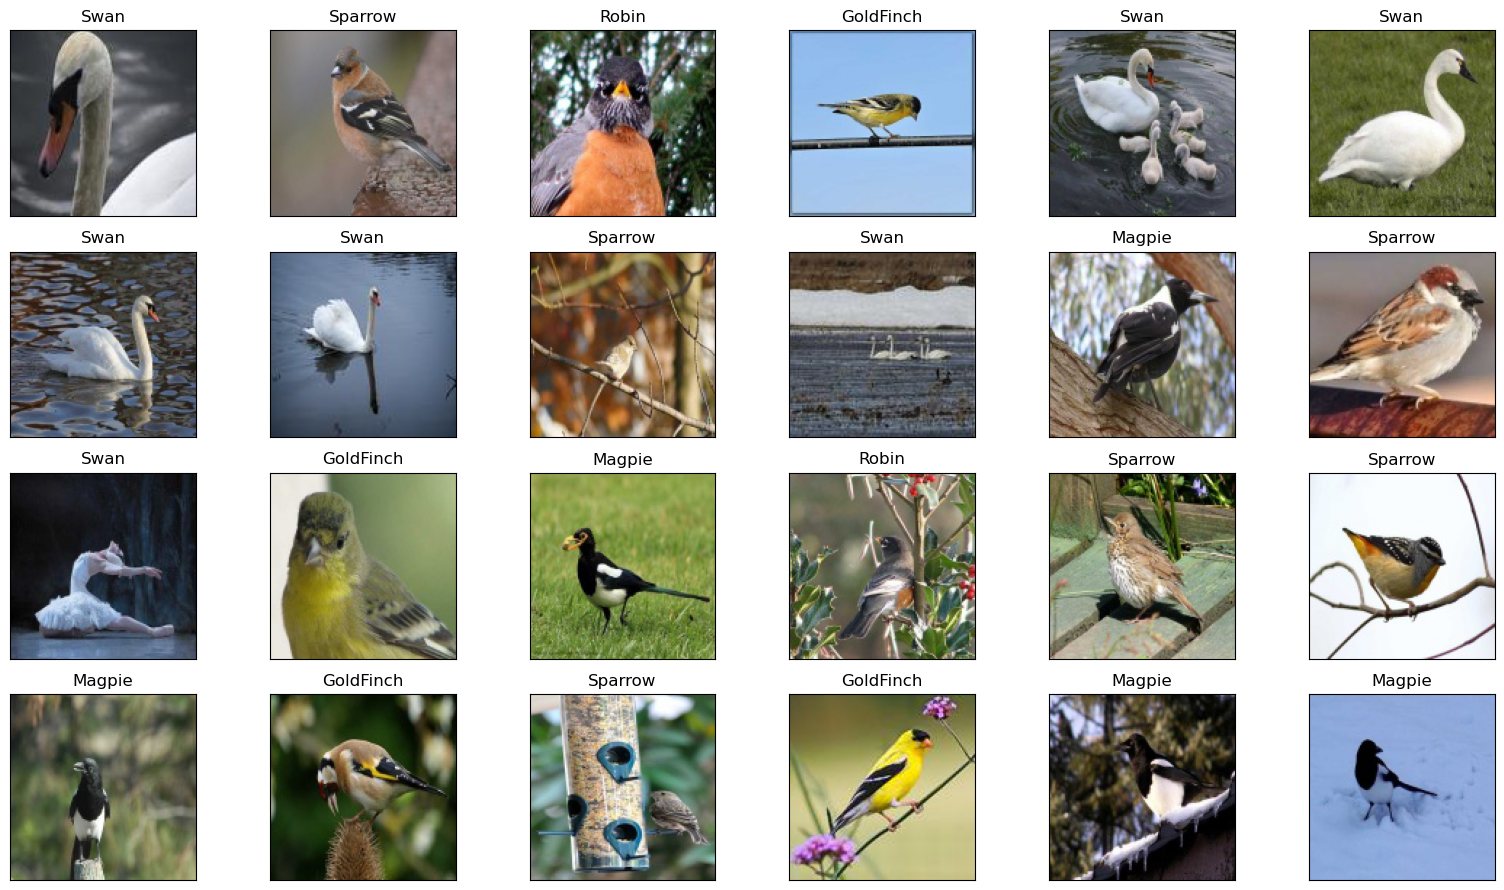

In [24]:
index = np.random.choice(np.arange(len(X_train)), 24, replace=False) #Select 24 random images to visualise
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 9)) #Create a 4x6 grid to display images

for item in zip(axes.ravel(), X_train[index], y_train[index]):
    axes, image, target = item
    axes.imshow(image) #Displays image in each subplot
    axes.set_xticks([])  # Remove x-axis tick marks
    axes.set_yticks([])  # Remove y-axis tick marks
    
    # Convert one-hot encoded target back to class name
    target_idx = np.argmax(target)  # Find the index of the 1 in the one-hot vector
    bird_name = class_names[target_idx]  # Get the corresponding class name
    
    axes.set_title(bird_name)  # Set the title as the bird name

plt.tight_layout() #Adjust spacing between subplots
plt.show() #Display grid

### Data augmentation

In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_datagen.fit(X_train)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 64)

### Visualise augmented dataset

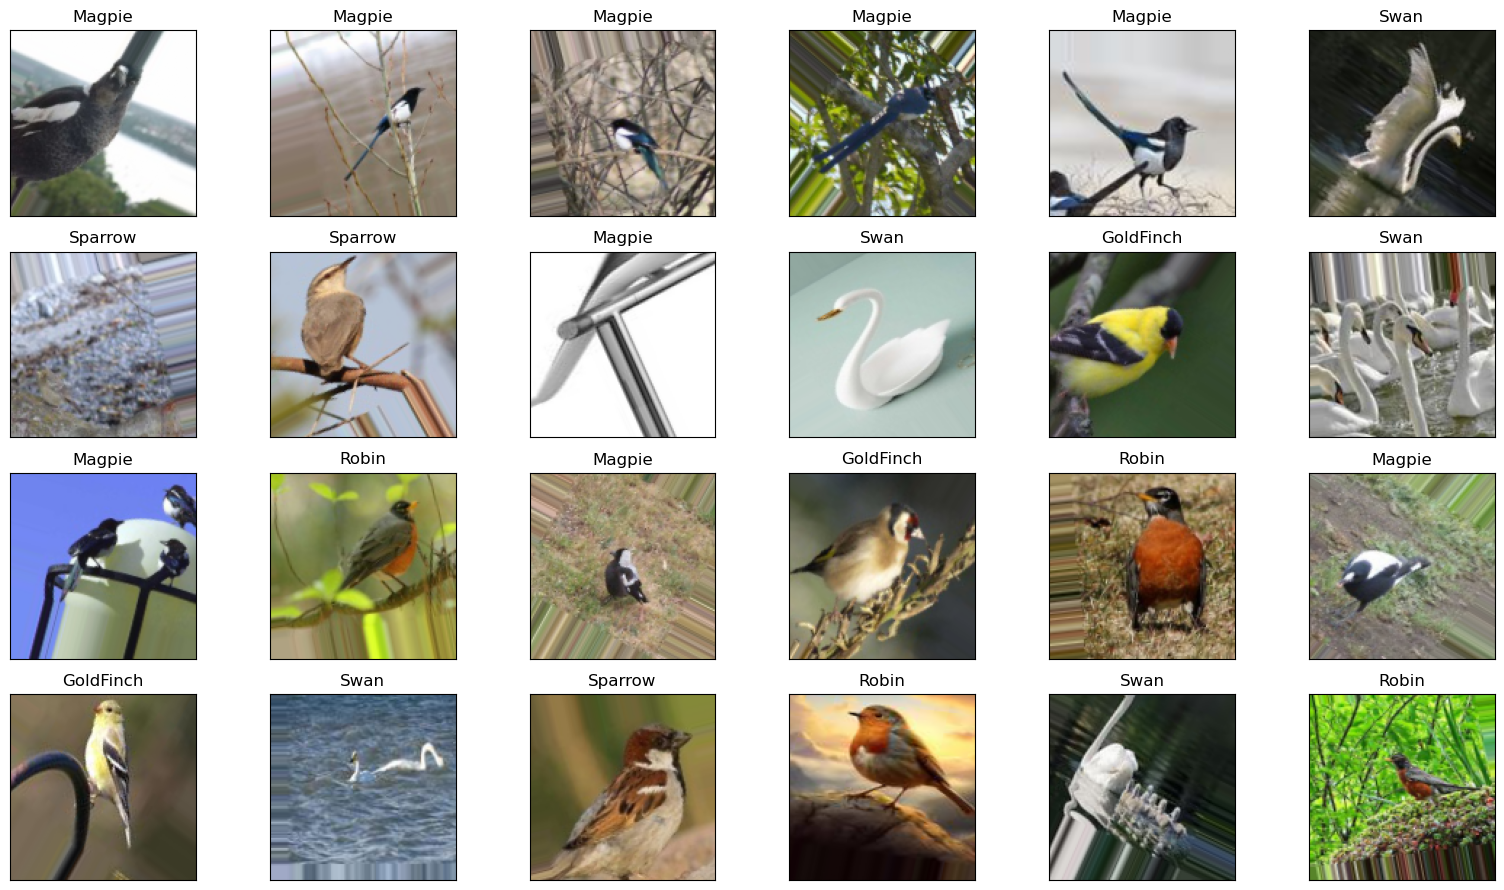

In [26]:
X_batch, y_batch = next(train_generator) 

figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 9))
index = np.random.choice(np.arange(len(X_batch)), 24, replace=False)

for item in zip(axes.ravel(), X_batch[index], y_batch[index]):
    axes, image, target = item
    axes.imshow(image)
    axes.set_xticks([])  # Remove x-axis tick marks
    axes.set_yticks([])  # Remove y-axis tick marks
    
    # Convert one-hot encoded target back to class name
    target_idx = np.argmax(target)  # Find the index of the 1 in the one-hot vector
    bird_name = class_names[target_idx]  # Get the corresponding class name
    
    axes.set_title(bird_name)  # Set the title as the bird name

plt.tight_layout()
plt.show()

### Converting data for neural network training

In [27]:
#Convert training and testing datasets to float32 data types
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

#Print the range of pixel values, should be between 0.0 and 1.0.
print("X_train range:", X_train.min(), X_train.max())
print("X_test range:", X_test.min(), X_test.max())

X_train range: 0.0 1.0
X_test range: 0.0 1.0


### Neural Network creation (CNN)

In [29]:
#Importing necessary tensorflow/keras functions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

activation = 'relu' #Defining the activation function
model = Sequential() #Initializing a Sequential model

#First Convolutional layer
model.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (128, 128, 3),
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization()) #Batch normalisation to normalize the output of the previous layer to improve training stability

#Second Convolutional layer
model.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D()) #Reduce spatial dimensions of feature maps, preserve highest value. Reduces risk of overfitting

#Third Convolutional layer
model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3)) #Dropout to reduce risk of overfitting by setting 30% of the nodes to zero during training.

#Fourth Convolutional layer
model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Flatten()) #Flatten results into a 1D vector
model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(5, activation = 'softmax'))

learning_rate = 0.001  #Learning rate for the Adam optimizer 
optimizer = Adam(learning_rate=learning_rate) #Initialize Adam optimizer

model.compile(optimizer = optimizer,loss = 'categorical_crossentropy', metrics = ['accuracy']) #Compiling the model, categorical crossentropy is used for multi-class classification.
print(model.summary()) #Display the summary of the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                      

### Visualize model

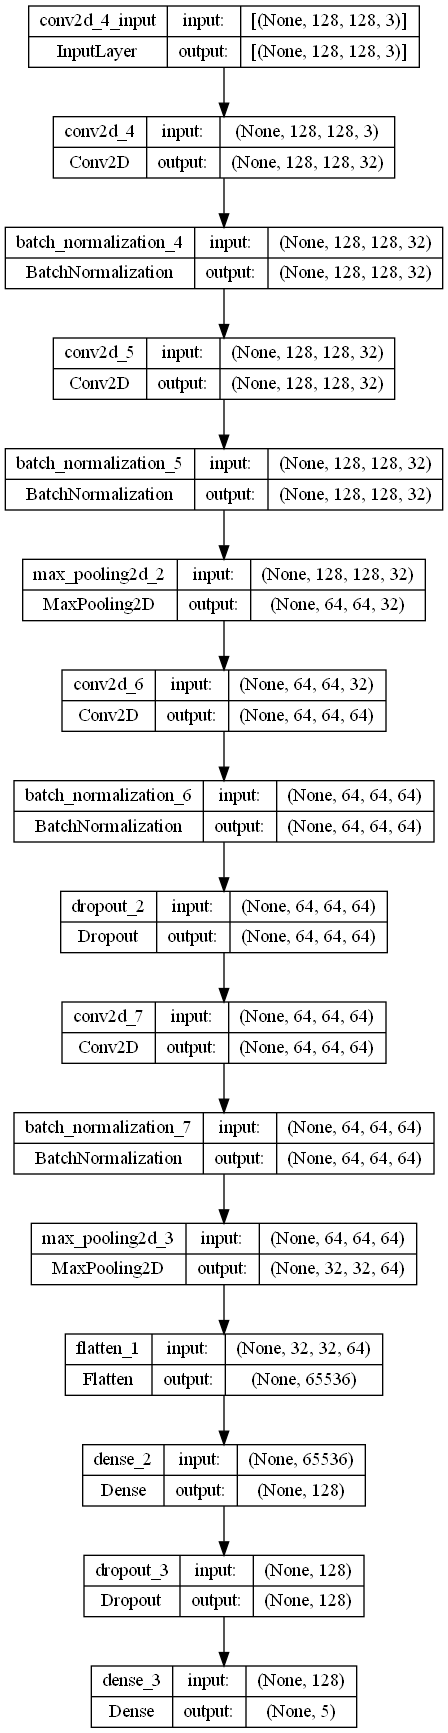

In [57]:
#Importing necessary functions
from tensorflow.keras.utils import plot_model
from IPython.display import Image

#Generates a plot of the model's structure
plot_model(model, to_file='convnet.png', show_shapes=True,
            show_layer_names=True)

#Display the generated image
Image(filename='convnet.png')

### Fit the model

In [30]:
history = model.fit(
    X_train, #Features
    y_train, #Labels
    epochs=50, #Number of epochs
    batch_size=batch_size, #Number of samples
    validation_data=(X_test, y_test) #Validation data to evaluate model performance after each epoch
)

Epoch 1/50
66/66 [==============================] - 71s 1s/step - loss: 8.1842 - accuracy: 0.2824 - val_loss: 69.6667 - val_accuracy: 0.1820
Epoch 2/50
66/66 [==============================] - 64s 976ms/step - loss: 4.3928 - accuracy: 0.3614 - val_loss: 58.7148 - val_accuracy: 0.2057
Epoch 3/50
66/66 [==============================] - 65s 983ms/step - loss: 4.0774 - accuracy: 0.3699 - val_loss: 123.0005 - val_accuracy: 0.1820
Epoch 4/50
66/66 [==============================] - 64s 971ms/step - loss: 3.7502 - accuracy: 0.3389 - val_loss: 163.8350 - val_accuracy: 0.1820
Epoch 5/50
66/66 [==============================] - 65s 988ms/step - loss: 3.3549 - accuracy: 0.4140 - val_loss: 27.7798 - val_accuracy: 0.2341
Epoch 6/50
66/66 [==============================] - 65s 980ms/step - loss: 3.0639 - accuracy: 0.4321 - val_loss: 67.8982 - val_accuracy: 0.1934
Epoch 7/50
66/66 [==============================] - 66s 1s/step - loss: 2.7464 - accuracy: 0.4771 - val_loss: 56.6801 - val_accuracy: 0.2

### Plotting training and validation loss

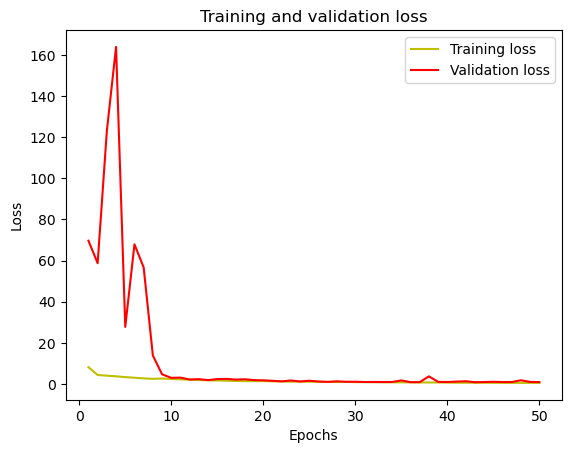

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting training and validation accuracy

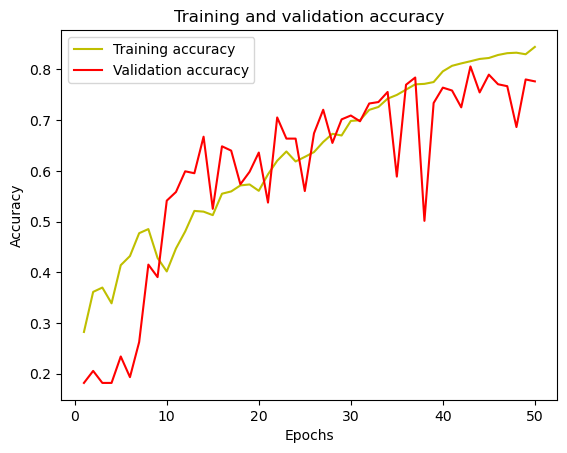

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')  # Changed label to 'accuracy'
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')  # Changed label to 'accuracy'
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion Matrix

33/33 [==============================] - 4s 101ms/step


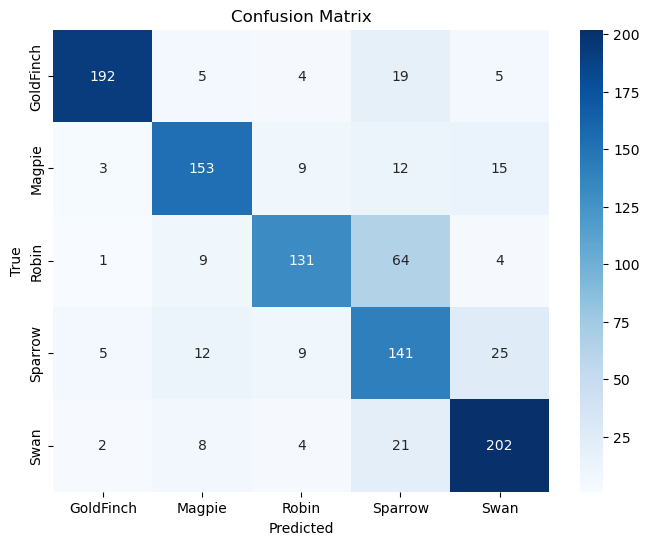

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

# Step 1: Get model predictions on the test set
y_pred = model.predict(X_test)

# Step 2: Convert one-hot encoded predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class indices
y_true_classes = np.argmax(y_test, axis=1)  # Convert true labels to class indices

# Step 3: Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Making a prediction

1/1 [==============================] - 0s 23ms/step


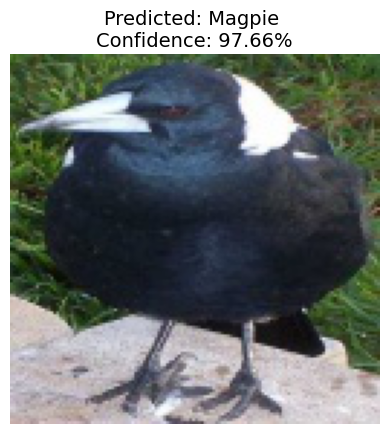

In [64]:
# Load and preprocess the image
img = load_img("pred_img.jpg", target_size=image_size)
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch axis
img_array = img_array / 255.0  # Normalize the image (as done during training)

# Predict the bird class
predictions = model.predict(img_array)

# Retrieve the class with the highest probability
predicted_index = np.argmax(predictions[0])  # Index of the predicted class
confidence = predictions[0][predicted_index] * 100  # Confidence percentage
# Display the predicted bird species and confidence
# Display the image with the predicted class and confidence
plt.imshow(img)
plt.axis('off')  # Hide the axis for better visualization
plt.title(f"Predicted: {class_names[predicted_index]} \nConfidence: {confidence:.2f}%", fontsize=14)
plt.show()

### Saving the model

In [43]:
!mkdir saved_model
model.save("saved_model/birds.h5")
print("Model saved to 'saved_model/birds.h5'")

A subdirectory or file saved_model already exists.


Model saved to 'saved_model/birds.h5'


### Loading the model

In [44]:
from tensorflow.keras.models import load_model

#Loads model from directory
loaded_model = load_model("saved_model/birds.h5")

#Display loaded model summary
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                      

### Making a prediction with the loaded model

1/1 [==============================] - 0s 111ms/step


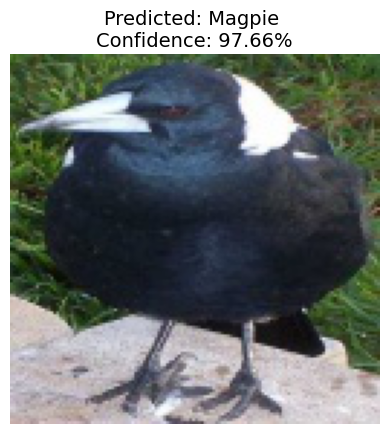

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the model
model = load_model("saved_model/birds.h5")

# Load and preprocess the image
img = load_img("pred_img.jpg", target_size=image_size)
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch axis
img_array = img_array / 255.0  # Normalize the image (as done during training)

# Predict the bird class
predictions = model.predict(img_array)

# Retrieve the class with the highest probability
predicted_index = np.argmax(predictions[0])  # Index of the predicted class
confidence = predictions[0][predicted_index] * 100  # Confidence percentage
# Display the predicted bird species and confidence
# Display the image with the predicted class and confidence
plt.imshow(img)
plt.axis('off')  # Hide the axis for better visualization
plt.title(f"Predicted: {class_names[predicted_index]} \nConfidence: {confidence:.2f}%", fontsize=14)
plt.show()